# Question 1a: Get to know the Data: WordCloud

In [57]:
# Start with loading all necessary libraries
import numpy as np
import pandas as pd
from os import path
import re
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import string
from collections import defaultdict

#sklearn libraries
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import stop_words as sk_sw

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import random as sparse_random
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.model_selection import KFold
from sklearn import model_selection, svm
from sklearn.model_selection import RepeatedKFold, cross_val_score


#library for Text Preprocessing
import nltk
nltk.download()
from nltk.corpus import stopwords  
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [2]:
dataset = pd.read_csv('train.csv')

df = pd.concat([dataset['Title'], dataset['Content'], dataset['Label']], axis=1)
df

,Title,Content,Label
0,"Netflix is coming to cable boxes, and Amazon i...",if you subscribe to one of three rinky-dink (...,Entertainment
1,"Pharrell, Iranian President React to Tehran 'H...","pharrell, iranian president react to tehran '...",Entertainment
2,Wildlife service seeks comments,the u.s. fish and wildlife service has reopen...,Technology
3,Facebook teams up with Storyful to launch 'FB ...,the very nature of social media means it is o...,Technology
4,Caesars plans US$880 mln New York casino,caesars plans us$880 mln new york casino jul ...,Business
...,...,...,...
111790,Microsoft requires Office 2013 licensing for s...,in contrast to the muckle of special licenses...,Technology
111791,Smallpox vials missing since 1950s found in la...,government workers at a research center near ...,Health
111792,Scientists May Have Just Discovered the Key to...,harvard scientists may have just unlocked the...,Health
111793,Justin Bieber to plead guilty to DUI,"justin bieber to plead guilty to duifri, 13 ju...",Entertainment


In [3]:
#Joining Title and Content column and separating them with '---' symbol 
df['United'] = df['Title'] + ' ' + df['Content']
df

,Title,Content,Label,United
0,"Netflix is coming to cable boxes, and Amazon i...",if you subscribe to one of three rinky-dink (...,Entertainment,"Netflix is coming to cable boxes, and Amazon i..."
1,"Pharrell, Iranian President React to Tehran 'H...","pharrell, iranian president react to tehran '...",Entertainment,"Pharrell, Iranian President React to Tehran 'H..."
2,Wildlife service seeks comments,the u.s. fish and wildlife service has reopen...,Technology,Wildlife service seeks comments the u.s. fish...
3,Facebook teams up with Storyful to launch 'FB ...,the very nature of social media means it is o...,Technology,Facebook teams up with Storyful to launch 'FB ...
4,Caesars plans US$880 mln New York casino,caesars plans us$880 mln new york casino jul ...,Business,Caesars plans US$880 mln New York casino caes...
...,...,...,...,...
111790,Microsoft requires Office 2013 licensing for s...,in contrast to the muckle of special licenses...,Technology,Microsoft requires Office 2013 licensing for s...
111791,Smallpox vials missing since 1950s found in la...,government workers at a research center near ...,Health,Smallpox vials missing since 1950s found in la...
111792,Scientists May Have Just Discovered the Key to...,harvard scientists may have just unlocked the...,Health,Scientists May Have Just Discovered the Key to...
111793,Justin Bieber to plead guilty to DUI,"justin bieber to plead guilty to duifri, 13 ju...",Entertainment,Justin Bieber to plead guilty to DUI justin bi...


### Stop Wrods

In [4]:
# Create stopword list:
nltk_sw = stopwords.words('english')
sklearn_stop_words = sk_sw.ENGLISH_STOP_WORDS

In [5]:
#Load from text file stop word for better performance
#the stop words file was taking from http://members.unine.ch/jacques.savoy/clef/englishST.txt
sw_list = []
with open('StopWords.txt', 'r') as f:
    [sw_list.append(word) for line in f for word in line.split()]

print("Lenghs of Stop Words from file ", len(sw_list))
print("Lenghs of Stop Words from NLTK Library ", len(nltk_sw))
print("Lenghs of Stop Words from Sklearn Library ", len(sklearn_stop_words))

Lenghs of Stop Words from file  571
Lenghs of Stop Words from NLTK Library  179
Lenghs of Stop Words from Sklearn Library  318


### Text Preprocessing

In [6]:
#Remove blank rows if any.
df['United'].dropna(inplace=True)

# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

corpus = df['United']
                  
#Removing punctuations and numbers.                
corpus = corpus.str.replace('[^\w\s]','') #punctuations
corpus = corpus.str.replace('\d+', '') #numbers

In [7]:
def text_preprocessing(text):
    #Change all the text to lower case.
    text = text.lower()

    #Tokenization : In this each entry in the corpus will be broken into set of words
    text_words_list = word_tokenize(text)

    #Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
    #Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    
    #Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(text_words_list):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in sw_list and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
    return str(Final_words)

In [8]:
df['United'] = corpus.map(text_preprocessing)

In [9]:
df

,Title,Content,Label,United
0,"Netflix is coming to cable boxes, and Amazon i...",if you subscribe to one of three rinky-dink (...,Entertainment,"['netflix', 'come', 'cable', 'box', 'amazon', ..."
1,"Pharrell, Iranian President React to Tehran 'H...","pharrell, iranian president react to tehran '...",Entertainment,"['pharrell', 'iranian', 'president', 'react', ..."
2,Wildlife service seeks comments,the u.s. fish and wildlife service has reopen...,Technology,"['wildlife', 'service', 'seek', 'comment', 'fi..."
3,Facebook teams up with Storyful to launch 'FB ...,the very nature of social media means it is o...,Technology,"['facebook', 'team', 'storyful', 'launch', 'fb..."
4,Caesars plans US$880 mln New York casino,caesars plans us$880 mln new york casino jul ...,Business,"['caesar', 'plan', 'mln', 'york', 'casino', 'c..."
...,...,...,...,...
111790,Microsoft requires Office 2013 licensing for s...,in contrast to the muckle of special licenses...,Technology,"['microsoft', 'require', 'office', 'licensing'..."
111791,Smallpox vials missing since 1950s found in la...,government workers at a research center near ...,Health,"['smallpox', 'vial', 'miss', 'find', 'lab', 's..."
111792,Scientists May Have Just Discovered the Key to...,harvard scientists may have just unlocked the...,Health,"['scientist', 'discover', 'key', 'reverse', 'a..."
111793,Justin Bieber to plead guilty to DUI,"justin bieber to plead guilty to duifri, 13 ju...",Entertainment,"['justin', 'bieber', 'plead', 'guilty', 'dui',..."


### Creating Word Cloud

In [10]:
def make_word_cloud(input_text, mask, output_file_name, stopwords=None, extra_stopwords=None,
                    bckgrd_color = "white", max_words=2000):

    # Load the mask image
    mask = np.array(Image.open(mask))
    
    # Load stop word list
    stopwords = set(stopwords)
    
    # Add extra stop words if provided
    if extra_stopwords is not None:
        [stopwords.add(word) for word in extra_stopwords]
    
    # Call WordCloud
    wc = WordCloud(background_color = bckgrd_color, max_words = max_words, collocations = False, relative_scaling=0,
                   mode="RGBA", mask = mask, stopwords = stopwords)

    # Generate word cloud
    wc.generate(input_text)
    
    # create coloring from image
    image_colors = ImageColorGenerator(mask)
    plt.figure(figsize=[7,7])
    plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")

    # store to file
    plt.savefig(output_file_name, format="png")

    plt.show()
    

In [11]:
tech = " ".join(text for text in df[df["Label"]=="Technology"].United)
enter = " ".join(text for text in df[df["Label"]=="Entertainment"].United)
busi = " ".join(text for text in df[df["Label"]=="Business"].United)
heal = " ".join(text for text in df[df["Label"]=="Health"].United)

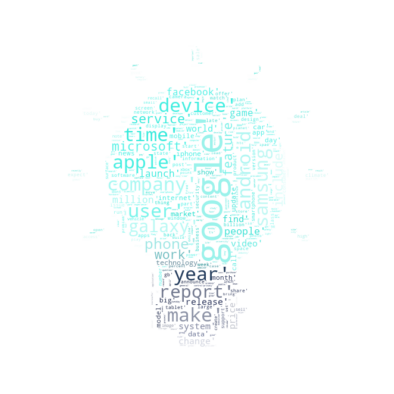

Word Cloud for Technology Label


In [12]:
# Generate a word cloud image for Techlonogy
make_word_cloud(input_text = tech, mask = "img/tech.jpg", output_file_name = "img/result_tech.png", stopwords = sw_list)

print("Word Cloud for Technology Label")

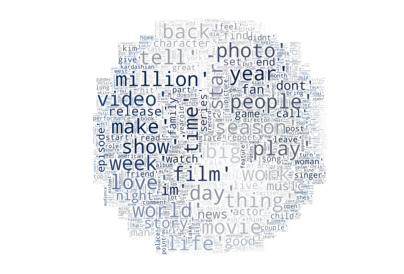

Word Cloud for Entertainment Label


In [13]:
# Generate a word cloud image for Techlonogy
make_word_cloud(input_text = enter, mask = "img/entertainment.png", output_file_name = "img/result_entertainment.png", 
                stopwords = sw_list)

print("Word Cloud for Entertainment Label")

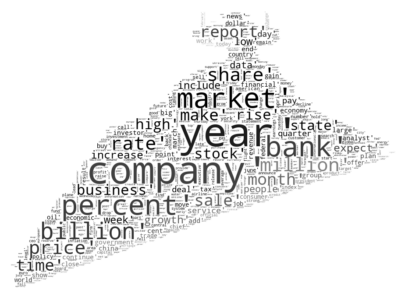

Word Cloud for Business Label


In [14]:
# Generate a word cloud image for Business 
make_word_cloud(input_text = busi, mask = "img/business.jpg", output_file_name = "img/result_business.png", stopwords = sw_list)

print("Word Cloud for Business Label")

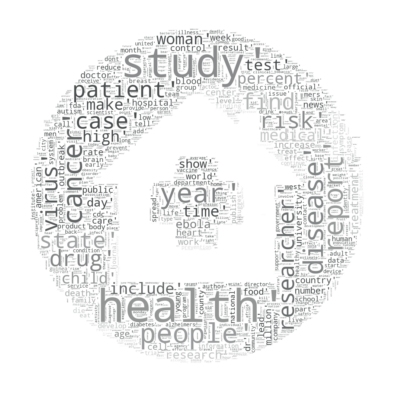

Word Cloud for Health Label


In [15]:
# Generate a word cloud image for Health
make_word_cloud(input_text = heal, mask = "img/health.jpg", output_file_name = "img/result_health.png", stopwords = sw_list)

print("Word Cloud for Health Label")

# Question 1b: Classification Task

 ### Split the model into Train and Test Dataset and Encoding

In [16]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df['United'], df['Label'], test_size=0.3)

In [18]:
#Label encode the target variable
#This is done to transform Categorical data of string type in the data set into numerical values
Encoder = LabelEncoder()
Encoder.fit(Train_Y)
Train_Y = Encoder.transform(Train_Y)
Test_Y = Encoder.transform(Test_Y)

### Creating the Bag of Words (BoW)

In [19]:
count_vec = CountVectorizer(max_features = 10000)
count_vec.fit(df['United'])
count_vec

CountVectorizer(max_features=10000)

In [20]:
spare_matrix = count_vec.transform(df['United'])

In [21]:
Train_X_Vec = count_vec.transform(Train_X)
Test_X_Vec = count_vec.transform(Test_X)

### SVM (BoW)

In [22]:
SVMClas_BoW = svm.SVC(C = 1.0, kernel = 'linear', degree = 3, gamma = 'auto')
SVMClas_BoW.fit(Train_X_Vec, Train_Y)

SVC(gamma='auto', kernel='linear')

In [23]:
# predict the labels on validation dataset
predictions_SVM_BoW = SVMClas_BoW.predict(Test_X_Vec)

In [24]:
print(classification_report(Test_Y, predictions_SVM_BoW, target_names = df['Label'].unique()))

               precision    recall  f1-score   support

Entertainment       0.89      0.92      0.90      7459
   Technology       0.98      0.98      0.98     13423
     Business       0.95      0.95      0.95      3619
       Health       0.94      0.92      0.93      9038

     accuracy                           0.95     33539
    macro avg       0.94      0.94      0.94     33539
 weighted avg       0.95      0.95      0.95     33539



### Random Forests (BoW)

In [25]:
RFClas_BoW = RandomForestClassifier(n_estimators = 100)
RFClas_BoW.fit(Train_X_Vec, Train_Y)

RandomForestClassifier()

In [26]:
# predict the labels on validation dataset
predictions_RF_BoW = RFClas_BoW.predict(Test_X_Vec)

In [27]:
print(classification_report(Test_Y, predictions_RF_BoW, target_names = df['Label'].unique()))

               precision    recall  f1-score   support

Entertainment       0.91      0.90      0.91      7459
   Technology       0.96      0.98      0.97     13423
     Business       0.96      0.90      0.93      3619
       Health       0.92      0.92      0.92      9038

     accuracy                           0.94     33539
    macro avg       0.94      0.92      0.93     33539
 weighted avg       0.94      0.94      0.94     33539



### My Method - Logistic Regression (BoW)

In [28]:
LGClas_BoW = LogisticRegression(max_iter = 10000, random_state = 0)
LGClas_BoW.fit(Train_X_Vec, Train_Y)

LogisticRegression(max_iter=10000, random_state=0)

In [29]:
predictions_LG_BoW = LGClas_BoW.predict(Test_X_Vec)

In [30]:
print(classification_report(Test_Y, predictions_LG_BoW, target_names = df['Label'].unique()))

               precision    recall  f1-score   support

Entertainment       0.92      0.92      0.92      7459
   Technology       0.98      0.98      0.98     13423
     Business       0.97      0.95      0.96      3619
       Health       0.94      0.94      0.94      9038

     accuracy                           0.95     33539
    macro avg       0.95      0.95      0.95     33539
 weighted avg       0.95      0.95      0.95     33539



### Creating the Singular Value Decomposition (SVD)

In [31]:
svd = TruncatedSVD(n_components = 5, n_iter = 7, random_state = 42)
svd.fit(spare_matrix)

TruncatedSVD(n_components=5, n_iter=7, random_state=42)

In [32]:
svd.transform(spare_matrix)

array([[ 3.00349290e+00, -3.60326463e-01,  3.73416219e-03,
         1.61444397e+00, -5.84706006e-01],
       [ 2.04676370e+00,  4.79730706e-02, -6.36475373e-01,
        -5.01986644e-01,  1.25071841e-01],
       [ 3.99276871e+00,  1.38119389e-01, -8.50946907e-02,
         1.08318056e+00,  1.56007403e+00],
       ...,
       [ 4.73855162e+00, -1.07045394e-02, -1.80324545e+00,
        -2.19784195e+00,  5.40502806e+00],
       [ 1.44973560e+00, -2.18431832e-02, -5.85598230e-01,
        -3.63746721e-01, -2.23043373e-02],
       [ 1.37615154e+00,  2.81094068e-01, -5.73145649e-01,
        -5.01959499e-01,  3.00647377e-01]])

In [33]:
Train_X_svd = svd.transform(Train_X_Vec)
Test_X_svd = svd.transform(Test_X_Vec)

### SVM (SVD)

In [34]:
SVMClas_SVD = svm.SVC(C = 1.0, kernel = 'linear', degree = 3, gamma = 'auto')
SVMClas_SVD.fit(Train_X_svd, Train_Y)

SVC(gamma='auto', kernel='linear')

In [35]:
# predict the labels on validation dataset
predictions_SVM_SVD = SVMClas_SVD.predict(Test_X_svd)

In [36]:
print(classification_report(Test_Y, predictions_SVM_SVD, target_names = df['Label'].unique()))

               precision    recall  f1-score   support

Entertainment       0.81      0.75      0.78      7459
   Technology       0.86      0.95      0.91     13423
     Business       0.82      0.72      0.77      3619
       Health       0.75      0.72      0.74      9038

     accuracy                           0.82     33539
    macro avg       0.81      0.79      0.80     33539
 weighted avg       0.82      0.82      0.82     33539



### Random Forests (SVD)

In [37]:
RFClas_SVD = RandomForestClassifier(n_estimators = 100)
RFClas_SVD.fit(Train_X_svd, Train_Y)

RandomForestClassifier()

In [38]:
predictions_RF_SVD = RFClas_SVD.predict(Test_X_svd)

In [39]:
print(classification_report(Test_Y, predictions_RF_SVD, target_names = df['Label'].unique()))

               precision    recall  f1-score   support

Entertainment       0.80      0.81      0.80      7459
   Technology       0.90      0.94      0.92     13423
     Business       0.82      0.78      0.80      3619
       Health       0.79      0.74      0.77      9038

     accuracy                           0.84     33539
    macro avg       0.83      0.82      0.82     33539
 weighted avg       0.84      0.84      0.84     33539



### My Method - Logistic Regression (SVD)

In [40]:
LGClas_SVD = LogisticRegression(max_iter = 10000, random_state = 0)
LGClas_SVD.fit(Train_X_svd, Train_Y)

LogisticRegression(max_iter=10000, random_state=0)

In [41]:
predictions_LG_SVD = LGClas_SVD.predict(Test_X_svd)

In [42]:
print(classification_report(Test_Y, predictions_LG_SVD, target_names = df['Label'].unique()))

               precision    recall  f1-score   support

Entertainment       0.81      0.74      0.77      7459
   Technology       0.85      0.96      0.90     13423
     Business       0.83      0.72      0.77      3619
       Health       0.76      0.71      0.74      9038

     accuracy                           0.82     33539
    macro avg       0.81      0.78      0.79     33539
 weighted avg       0.81      0.82      0.81     33539



# 5-Fold Cross Validation

In [43]:
kf = KFold(n_splits = 5)
SVMClf = svm.SVC(C = 1.0, kernel = 'linear', degree = 3, gamma = 'auto')

for train_index, test_index in kf.split(df['United'], df['Label']):
    X_train_counts = count_vec.transform(np.array(df['United'])[train_index])
    X_test_counts = count_vec.transform(np.array(df['United'])[test_index])
    
    clf_cv = SVMClf.fit(X_train_counts, np.array(df['Label'])[train_index])
    yPred = clf_cv.predict(X_test_counts)
    yTrue = np.array(df['Label'])[test_index]
    print(classification_report(yPred, yTrue, target_names = df['Label'].unique()))

               precision    recall  f1-score   support

Entertainment       0.91      0.90      0.90      5070
   Technology       0.98      0.98      0.98      8964
     Business       0.95      0.96      0.96      2348
       Health       0.92      0.94      0.93      5977

     accuracy                           0.95     22359
    macro avg       0.94      0.94      0.94     22359
 weighted avg       0.95      0.95      0.95     22359

               precision    recall  f1-score   support

Entertainment       0.92      0.90      0.91      5150
   Technology       0.98      0.98      0.98      8920
     Business       0.94      0.96      0.95      2379
       Health       0.92      0.94      0.93      5910

     accuracy                           0.95     22359
    macro avg       0.94      0.94      0.94     22359
 weighted avg       0.95      0.95      0.95     22359

               precision    recall  f1-score   support

Entertainment       0.91      0.89      0.90      4986
   

### Using Pipelines

In [51]:
Encoder1 = LabelEncoder()
Encoder1.fit(df['Label'])
y = Encoder1.transform(df['Label'])

In [44]:
SVM_bow = Pipeline([("SVM", svm.SVC(C = 1.0, kernel = 'linear', degree = 3, gamma = 'auto'))])
RF_bow = Pipeline([("Random Forest", RandomForestClassifier(n_estimators = 100))])
SVM_svd = Pipeline([('feat', TruncatedSVD(n_components = 5, n_iter = 7, random_state = 42)), ("SVM", svm.SVC(C = 1.0, kernel = 'linear', degree = 3, gamma = 'auto'))])
RF_svd = Pipeline([('feat', TruncatedSVD(n_components = 5, n_iter = 7, random_state = 42)), ("Random Forest", RandomForestClassifier(n_estimators = 100))])
LR_bow = Pipeline([("Logistic Regression", LogisticRegression(max_iter = 10000, random_state = 0))])

In [45]:
models=[
    ("SVM (BoW)", SVM_bow),
    ("Random Forest (BoW)", RF_bow),
    ("SVM (SVD)", SVM_svd),
    ("Random Forest (SVD)", RF_svd),
    ("My Method", LR_bow)
]

In [46]:
#Model evaluation function
d = {'Statistic Measure': ['Accuracy', 'Precision', 'Recall', 'F-Measure']}
evaluation = pd.DataFrame(data=d).set_index('Statistic Measure')

In [58]:
# Applying K-folds for pipeline
kf = KFold(n_splits=5) 
for name, model in models:
	s = pd.Series()
	for train, test in kf.split(spare_matrix):
		X_train, X_test = spare_matrix[train], spare_matrix[test]
		y_train, y_test = y[train], y[test]
		train = model.fit(X_train, y_train)
		ypred = model.predict(X_test)
	d = [accuracy_score(y_test, ypred), precision_score(y_test, ypred, average = 'macro'), recall_score(y_test, ypred, average = 'macro'), f1_score(y_test, ypred, average = 'macro')]
	evaluation[name] = d

<ipython-input-58-c60020fb7b01>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-58-c60020fb7b01>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-58-c60020fb7b01>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-58-c60020fb7b01>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()


In [59]:
d = [accuracy_score(y_test, ypred), precision_score(y_test, ypred, average = 'macro'), recall_score(y_test, ypred, average = 'macro'), f1_score(y_test, ypred, average = 'macro')]
evaluation[name] = d

In [60]:
print(evaluation)

                   SVM (BoW)  Random Forest (BoW)  SVM (SVD)  \
Statistic Measure                                              
Accuracy            0.947135             0.939174   0.824366   
Precision           0.942882             0.940146   0.817898   
Recall              0.940326             0.926827   0.792269   
F-Measure           0.941523             0.933147   0.803244   

                   Random Forest (SVD)  My Method  
Statistic Measure                                  
Accuracy                      0.845029   0.956214  
Precision                     0.832741   0.953492  
Recall                        0.822230   0.950150  
F-Measure                     0.827028   0.951793  


In [61]:
evaluation.to_csv('5fold_1a.csv', sep = ',')

## Preporcessing test dataset

In [62]:
test_dataset = pd.read_csv('test_without_labels.csv', sep = ',')

test_dataset['United'] = test_dataset['Title'] + ' ' + test_dataset['Content']
test_dataset['United'].dropna(inplace=True)

corpus_test = test_dataset['United']
                  
#Removing punctuations and numbers.                
corpus_test = corpus_test.str.replace('[^\w\s]','') #punctuations
corpus_test = corpus_test.str.replace('\d+', '') #numbers

test_dataset['United'] = corpus_test.map(text_preprocessing)

In [65]:
test_count_vector  = count_vec.transform(test_dataset['United'])
id_n = test_dataset['Id']

predictions = RFClas_BoW.predict(test_count_vector)

prediction_table = pd.DataFrame(data = id_n, columns = ['Id'])
prediction_table['Predicted'] = predictions

for i in range(prediction_table.shape[0]):
    if prediction_table['Predicted'][i] == 0:
        prediction_table['Predicted'][i] = 'Business'
    if prediction_table['Predicted'][i] == 1:
        prediction_table['Predicted'][i] = 'Entertainment'
    if prediction_table['Predicted'][i] == 2:
        prediction_table['Predicted'][i] = 'Health'
    if prediction_table['Predicted'][i] == 3:
        prediction_table['Predicted'][i] = 'Technology'
        
prediction_table.to_csv('testSet_categories.csv', sep =',', index = False)

<ipython-input-65-a95d188f4809>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_table['Predicted'][i] = 'Business'
<ipython-input-65-a95d188f4809>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_table['Predicted'][i] = 'Entertainment'
<ipython-input-65-a95d188f4809>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_table['Predicted'][i] = 'Technology'
<ipython-input-65-a95d188f4809>:15: SettingWithC